## File loading

In [1]:
print('Start')

Start


In [2]:
import numpy as np 
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from IPython.display import FileLink
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import warnings
import copy
import glob
import sys
import os
import shutil

warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
%%capture
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:

try:
    df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv', delimiter=',')
except FileNotFoundError as e:
    print(f"Error: {e}")
    

# A basic overview of the NIH chest x-ray data.

We will use some exploratory functions to see what this data looks like.
head(), describe().

In [5]:
df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [6]:
df.describe()

Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112120.000000  112120.000000  112120.000000        112120.000000   
mean        8.573751   14346.381743      46.901463          2646.078844   
std        15.406320    8403.876972      16.839923           341.246429   
min         0.000000       1.000000       1.000000          1143.000000   
25%         0.000000    7310.750000      35.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000     414.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  Unnamed: 11  
count  112120.000000                112120.000000  112120.000000          0.0  
mean     2486.438842                     0.155649       0.155649          NaN  
std       401.268227                     0.016174       0.016174          NaN  
min       966.000000                     0.115000       0.115000          NaN  
25%      2048.000000                     0.143000       0.143000          NaN  
50%      2544.000000                     0.143000       0.143000          NaN  
75%      2991.000000                     0.168000       0.168000          NaN  
max      4715.000000                     0.198800       0.198800          NaN

## Data cleaning and preprocessing

In [7]:
column_list = df.columns.tolist()
print(column_list)

['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']


In [8]:
# Split the 'Findings' column into separate conditions
df['Conditions'] = df['Finding Labels'].str.split('|')

# This will give you a new column 'Conditions' where each entry is a list of conditions

df['Num Conditions'] = df['Conditions'].apply(len)

df_exploded = df.explode('Conditions')

In [9]:
# Split the 'Finding Labels' column into separate conditions
df['Conditions'] = df['Finding Labels'].str.split('|')

# Convert the list of conditions to a string
df['Conditions'] = df['Conditions'].apply(lambda x: ' '.join(x))

# Create dummy variables for each condition
condition_dummies = df['Conditions'].str.get_dummies(sep=' ')

# Concatenate the original DataFrame with the dummy DataFrame
df = pd.concat([df, condition_dummies], axis=1)

From calling df.head() we can see that the conditions are listed in the column 'Finding Label' which we can extract.

In [10]:
df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x  ...  Fibrosis  Finding Hernia  Infiltration  \
0                        0.143  ...         0        0      0             0   
1                        0.143  ...         0        0      0             0   
2                        0.168  ...         0        0      0             0   
3                        0.171  ...         0        1      0             0   
4                        0.143  ...         0        0      1             0   

   Mass  No  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
0     0   0       0                   0          0             0  
1     0   0       0                   0          0             0  
2     0   0       0                   0          0             0  
3     0   1       0                   0          0             0  
4     0   0       0                   0          0             0  

[5 rows x 30 columns]

Split the 'Finding Labels' colmumn into separate conditions.

In [11]:
# Select relevant columns
df = df[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

# Make sure the labels are of the string type
df['Finding Labels'] = df['Finding Labels'].astype(str)

# Split the labels into the different conditions
df['Finding Labels'] = df['Finding Labels'].str.split('|')

# The list of conditions
pathology_list = ['No Finding','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Create new columns for each disease
def create_disease_columns(dataframe, pathology_list):
    for pathology in pathology_list:
        dataframe[pathology] = dataframe['Finding Labels'].apply(lambda x: int(pathology in x))
    return dataframe

# Call the function with the dataframe and pathology_list
df = create_disease_columns(df, pathology_list)

In [12]:
df.tail()

Image Index     Finding Labels  Follow-up #  Patient ID  \
112115  00030801_001.png  [Mass, Pneumonia]            1       30801   
112116  00030802_000.png       [No Finding]            0       30802   
112117  00030803_000.png       [No Finding]            0       30803   
112118  00030804_000.png       [No Finding]            0       30804   
112119  00030805_000.png       [No Finding]            0       30805   

        Patient Age Patient Gender  No Finding  Cardiomegaly  Consolidation  \
112115           39              M           0             0              0   
112116           29              M           1             0              0   
112117           42              F           1             0              0   
112118           30              F           1             0              0   
112119           27              M           1             0              0   

        Edema  Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  \
112115      0         0          0         0       0             0     1   
112116      0         0          0         0       0             0     0   
112117      0         0          0         0       0             0     0   
112118      0         0          0         0       0             0     0   
112119      0         0          0         0       0             0     0   

        Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
112115       0                   0          1             0  
112116       0                   0          0             0  
112117       0                   0          0             0  
112118       0                   0          0             0  
112119       0                   0          0             0

In [13]:
# Drop the 'Finding Labels' column
df = df.drop('Finding Labels', axis=1)

In [14]:
df.tail()

Image Index  Follow-up #  Patient ID  Patient Age Patient Gender  \
112115  00030801_001.png            1       30801           39              M   
112116  00030802_000.png            0       30802           29              M   
112117  00030803_000.png            0       30803           42              F   
112118  00030804_000.png            0       30804           30              F   
112119  00030805_000.png            0       30805           27              M   

        No Finding  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  \
112115           0             0              0      0         0          0   
112116           1             0              0      0         0          0   
112117           1             0              0      0         0          0   
112118           1             0              0      0         0          0   
112119           1             0              0      0         0          0   

        Fibrosis  Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  \
112115         0       0             0     1       0                   0   
112116         0       0             0     0       0                   0   
112117         0       0             0     0       0                   0   
112118         0       0             0     0       0                   0   
112119         0       0             0     0       0                   0   

        Pneumonia  Pneumothorax  
112115          1             0  
112116          0             0  
112117          0             0  
112118          0             0  
112119          0             0

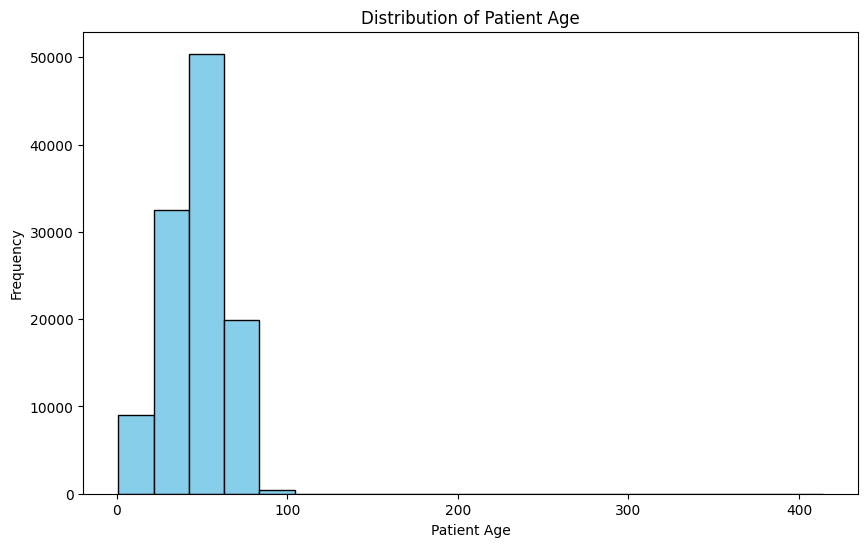

In [15]:
# Create a histogram of the 'Patient Age' column
plt.figure(figsize=(10,6))
plt.hist(df['Patient Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Age')

# Display the plot
plt.show()

We can see that a majority of the patients are between the ages of 0 and 100. There are a few that are above 100 years old and  of those were above the current record of 122 years old. We can look deeper into this and make changes as there is a high chance that those are errors.

In [16]:
# Create a boolean mask for ages greater than 100
mask = df['Patient Age'] > 100

# Use the mask to filter the DataFrame
filtered_df = df[mask]

# Get the number of rows in the filtered DataFrame
num_persons = filtered_df.shape[0]

print(num_persons)

16


In [17]:
# Create a boolean mask for ages less than or equal to 100
mask = df['Patient Age'] <= 100

# Use the mask to filter the DataFrame
df = df[mask]

After removing the patients with ages above the current record of 122 years old, we can visualise the age distribution again.

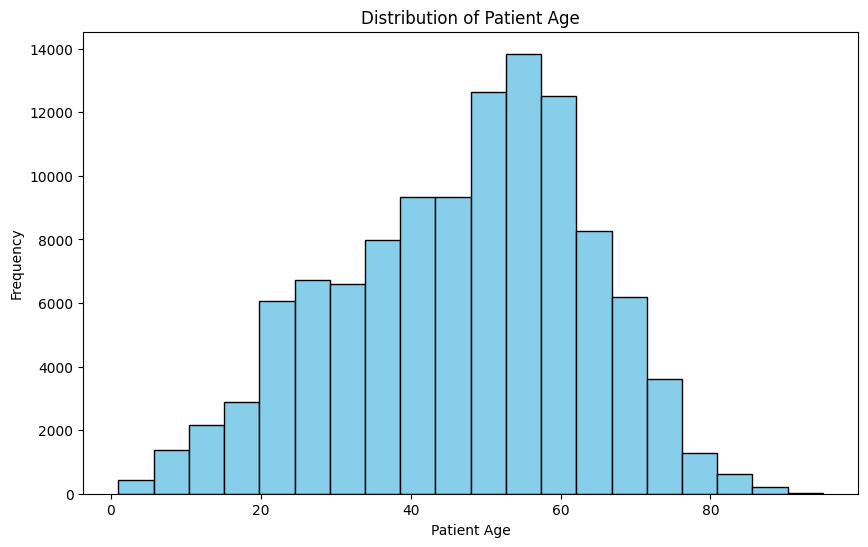

In [18]:
# Create a histogram of the 'Patient Age' column
plt.figure(figsize=(10,6))
plt.hist(df['Patient Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Age')

# Display the plot
plt.show()

In [19]:
# Loop through the conditions and print their sum total in the data
pathology_list = ['No Finding','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

for condition in pathology_list:
    print(f"{condition}: {df[condition].sum()}")

No Finding: 60353
Cardiomegaly: 2776
Consolidation: 4667
Edema: 2302
Effusion: 13316
Emphysema: 2516
Fibrosis: 1686
Hernia: 227
Infiltration: 19891
Mass: 5779
Nodule: 6331
Pleural_Thickening: 3384
Pneumonia: 1430
Pneumothorax: 5301


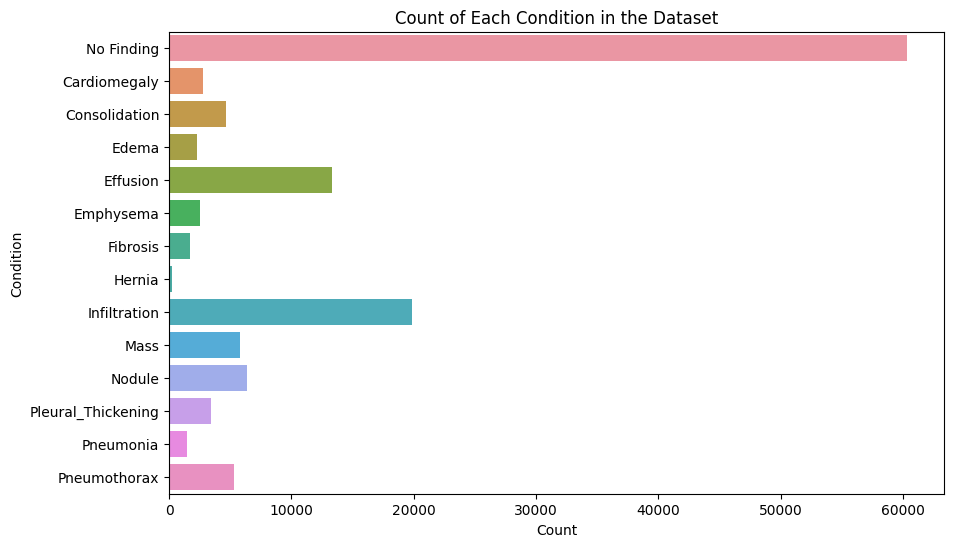

In [20]:
# Set the default palette
sns.set_palette('viridis')

# Create a list to store the counts of each condition
condition_counts = [df[pathology].sum() for pathology in pathology_list]

# Create a DataFrame from the condition counts
data = pd.DataFrame({
    'Condition': pathology_list,
    'Count': condition_counts
})

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(y='Condition', x='Count', data=data)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Condition')
plt.title('Count of Each Condition in the Dataset')

# Display the chart
plt.show()

## Chest x-rays with findings vs no findings.

We can see that approximately 54% of the chest x-rays in this dataset are labelled as having no findings, this can present challenges or learning opportunities depending on what we want to do with our data.
We may want to know what features differentiate those with no findings from those with findings. 

For machine learning we may want to take measures to ensure having a large number of ‘No Finding’ images does not bias the model towards predicting ‘No Finding'.

In [21]:
# Create age groups
bins = list(range(0, 101, 10))  # Creates bins from 0 to 130 with a step of 10
labels = [f'{i}-{i+9}' for i in range(0, 100, 10)]  # Creates labels for these bins
df['Age Group'] = pd.cut(df['Patient Age'], bins=bins, labels=labels, right=False)

# Calculate % of total per age group
total_patients = df.shape[0]
df_total = df['Age Group'].value_counts().sort_index() / total_patients * 100

# Calculate % of no findings per age group
df_no_findings = df[df['No Finding'] == 1].groupby('Age Group').size() / df.groupby('Age Group').size() * 100

# Combine both series into a dataframe
age_analysis_df = pd.concat([df_total, df_no_findings], axis=1)
age_analysis_df.columns = ['% of Total', '% of No Findings']

# Print the dataframe
print(age_analysis_df)

           % of Total  % of No Findings
Age Group                              
0-9          1.251516         59.871703
10-19        4.835688         58.254935
20-29       11.416185         57.462103
30-39       14.551666         58.413535
40-49       19.384679         55.851088
50-59       24.446942         51.988616
60-69       17.191180         48.988169
70-79        5.923963         47.718717
80-89        0.940198         42.884250
90-99        0.057982         38.461538


We see that there the trend is for the number of x-rays with 'No findings' to decrease with age. About 50.4% of those <10 have no finding dropping off to 28.4% with no findings in the nineties, this is in keeping with what we may expect as health issues tend to increase with age.

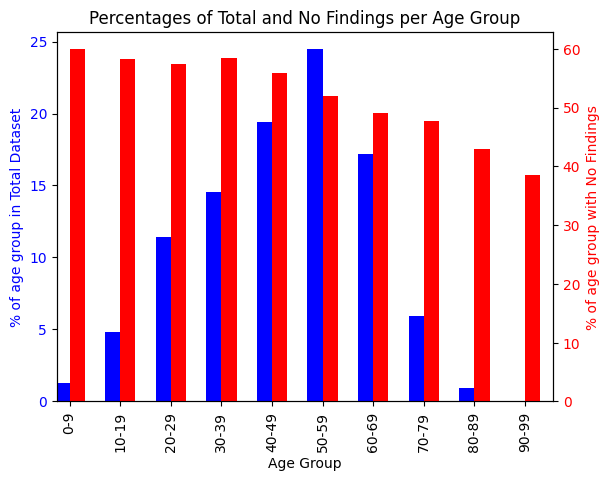

In [22]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot % of Total
age_analysis_df['% of Total'].plot(kind='bar', color='blue', ax=ax1, width=0.3, position=1)
ax1.set_ylabel('% of age group in Total Dataset', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the same plot
ax2 = ax1.twinx()

# Plot % of No Findings on the second y-axis
age_analysis_df['% of No Findings'].plot(kind='bar', color='red', ax=ax2, width=0.3, position=0)
ax2.set_ylabel('% of age group with No Findings', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the x-axis label
ax1.set_xlabel('Age Group')

# Set the plot title
plt.title('Percentages of Total and No Findings per Age Group')

# Show the plot
plt.show()

In [23]:
# Calculate the statistical summary for 'Follow-up #' for each age group
follow_up_summary = df.groupby('Age Group', observed=True)['Follow-up #'].describe()

print(follow_up_summary)

             count       mean        std  min  25%  50%   75%    max
Age Group                                                           
0-9         1403.0   7.114754  13.337775  0.0  0.0  1.0   7.0   80.0
10-19       5421.0   8.788046  13.999377  0.0  0.0  3.0  11.0  157.0
20-29      12798.0  10.170574  18.075101  0.0  0.0  3.0  11.0  151.0
30-39      16313.0   8.825783  15.235733  0.0  0.0  3.0  11.0  156.0
40-49      21731.0   7.827389  13.920925  0.0  0.0  3.0   9.0  142.0
50-59      27406.0   9.112895  17.577098  0.0  0.0  3.0  10.0  183.0
60-69      19272.0   7.872042  12.849892  0.0  0.0  3.0   9.0  113.0
70-79       6641.0   7.657883  13.958591  0.0  0.0  3.0   8.0  118.0
80-89       1054.0   6.272296   9.555300  0.0  0.0  2.0   8.0   54.0
90-99         65.0   6.415385   6.573841  0.0  1.0  5.0  11.0   23.0


Patient gender doesn't seem to have much on an impact on wether there are findings or not. This may not be surprising information.

In [24]:
gender_analysis = df.groupby('Patient Gender')['No Finding'].mean()
print(gender_analysis)

Patient Gender
F    0.542008
M    0.535561
Name: No Finding, dtype: float64


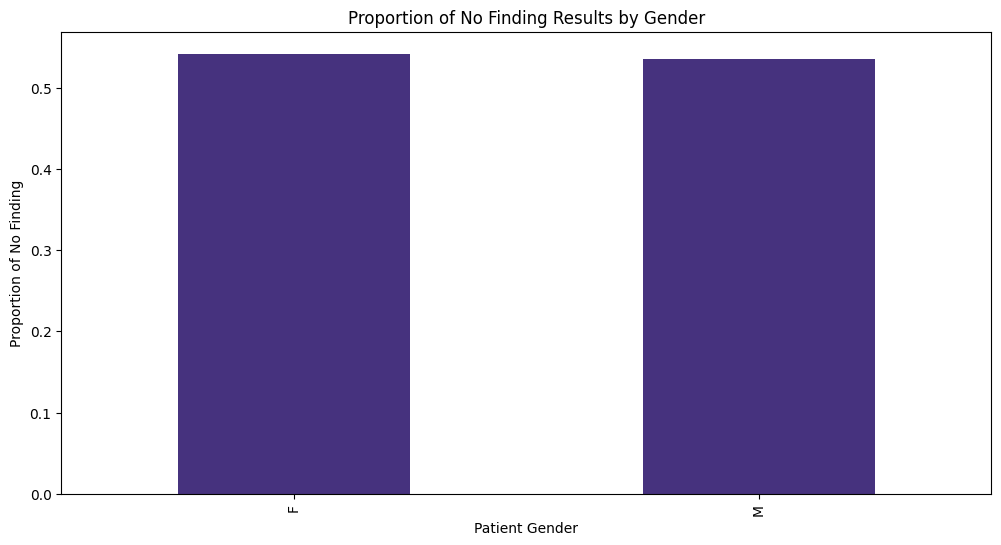

In [25]:
# Set the color palette
sns.set_palette('viridis')

# Create a bar plot
plt.figure(figsize=(12,6))
gender_analysis.plot(kind='bar')

# Set the plot labels and title
plt.xlabel('Patient Gender')
plt.ylabel('Proportion of No Finding')
plt.title('Proportion of No Finding Results by Gender')

# Show the plot
plt.show()

In [26]:
df.columns

Index(['Image Index', 'Follow-up #', 'Patient ID', 'Patient Age',
       'Patient Gender', 'No Finding', 'Cardiomegaly', 'Consolidation',
       'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax',
       'Age Group'],
      dtype='object')

In [27]:
# Load the images
root_folder = "/kaggle/input/data/"

# Use glob to get all PNG images from the subfolders
try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")

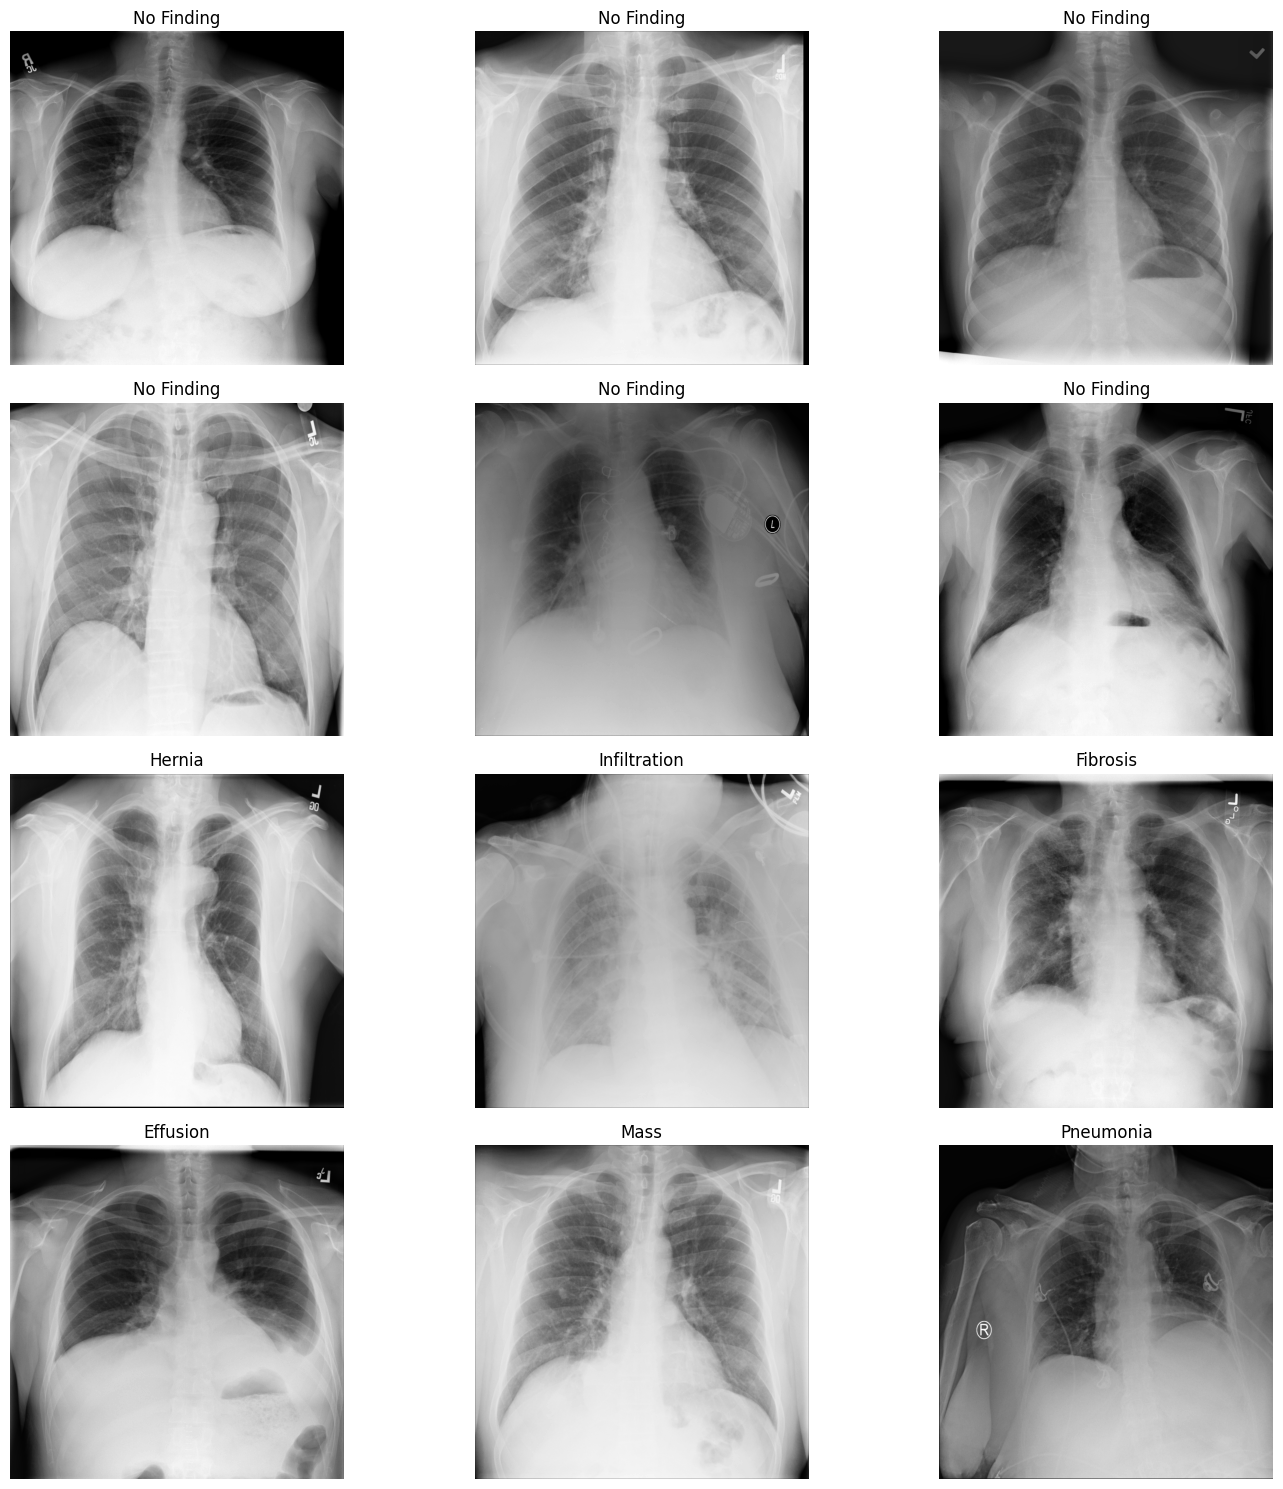

In [28]:
# Select 6 random pathologies
selected_pathologies = np.random.choice(pathology_list[1:], 6, replace=False)  # Exclude 'No Finding'

# Select one image from each selected pathology
other_pathology_images = [df[df[pathology] == 1].sample(1)['Image Index'].values[0] for pathology in selected_pathologies]

# Set aside 6 images from 'No Finding'
no_finding_images = df[df['No Finding'] == 1].sample(6)['Image Index'].values

# Now you have 6 images from 'No Finding' and 1 from each of the 6 selected pathologies
selected_images = list(no_finding_images) + other_pathology_images

image_paths_dict = {os.path.basename(path): path for path in image_paths}

# Create a figure with subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

for i, img_name in enumerate(selected_images):
    # Load the image
    img_path = image_paths_dict[img_name]
    img = mpimg.imread(img_path)
    
    # Find the corresponding pathology
    pathology = df[df['Image Index'] == img_name][pathology_list].idxmax(axis=1).values[0]
    
    # Display the image in a subplot
    ax = axes[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(pathology)

# Remove empty subplots
if len(selected_images) < 12:
    for i in range(len(selected_images), 12):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

# Problem scope reduction

We will reduce the scope of the problem to train the model to classify 5 common conditions. 

We will use a maximum of 3000 images per condition (this helped to reduce the number of files required).

In [29]:
df.head()

Image Index  Follow-up #  Patient ID  Patient Age Patient Gender  \
0  00000001_000.png            0           1           58              M   
1  00000001_001.png            1           1           58              M   
2  00000001_002.png            2           1           58              M   
3  00000002_000.png            0           2           81              M   
4  00000003_000.png            0           3           81              F   

   No Finding  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  \
0           0             1              0      0         0          0   
1           0             1              0      0         0          1   
2           0             1              0      0         1          0   
3           1             0              0      0         0          0   
4           0             0              0      0         0          0   

   Fibrosis  Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  \
0         0       0             0     0       0                   0   
1         0       0             0     0       0                   0   
2         0       0             0     0       0                   0   
3         0       0             0     0       0                   0   
4         0       1             0     0       0                   0   

   Pneumonia  Pneumothorax Age Group  
0          0             0     50-59  
1          0             0     50-59  
2          0             0     50-59  
3          0             0     80-89  
4          0             0     80-89

In [30]:
# Load the images
root_folder = "/kaggle/input/data/"

In [31]:
try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")

In [32]:
df.tail()

Image Index  Follow-up #  Patient ID  Patient Age Patient Gender  \
112115  00030801_001.png            1       30801           39              M   
112116  00030802_000.png            0       30802           29              M   
112117  00030803_000.png            0       30803           42              F   
112118  00030804_000.png            0       30804           30              F   
112119  00030805_000.png            0       30805           27              M   

        No Finding  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  \
112115           0             0              0      0         0          0   
112116           1             0              0      0         0          0   
112117           1             0              0      0         0          0   
112118           1             0              0      0         0          0   
112119           1             0              0      0         0          0   

        Fibrosis  Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  \
112115         0       0             0     1       0                   0   
112116         0       0             0     0       0                   0   
112117         0       0             0     0       0                   0   
112118         0       0             0     0       0                   0   
112119         0       0             0     0       0                   0   

        Pneumonia  Pneumothorax Age Group  
112115          1             0     30-39  
112116          0             0     20-29  
112117          0             0     40-49  
112118          0             0     30-39  
112119          0             0     20-29

No Finding: 60353
Cardiomegaly: 2776
Consolidation: 4667
Edema: 2302
Effusion: 13316
Emphysema: 2516
Fibrosis: 1686
Hernia: 227
Infiltration: 19891
Mass: 5779
Nodule: 6331
Pleural_Thickening: 3384
Pneumonia: 1430
Pneumothorax: 5301

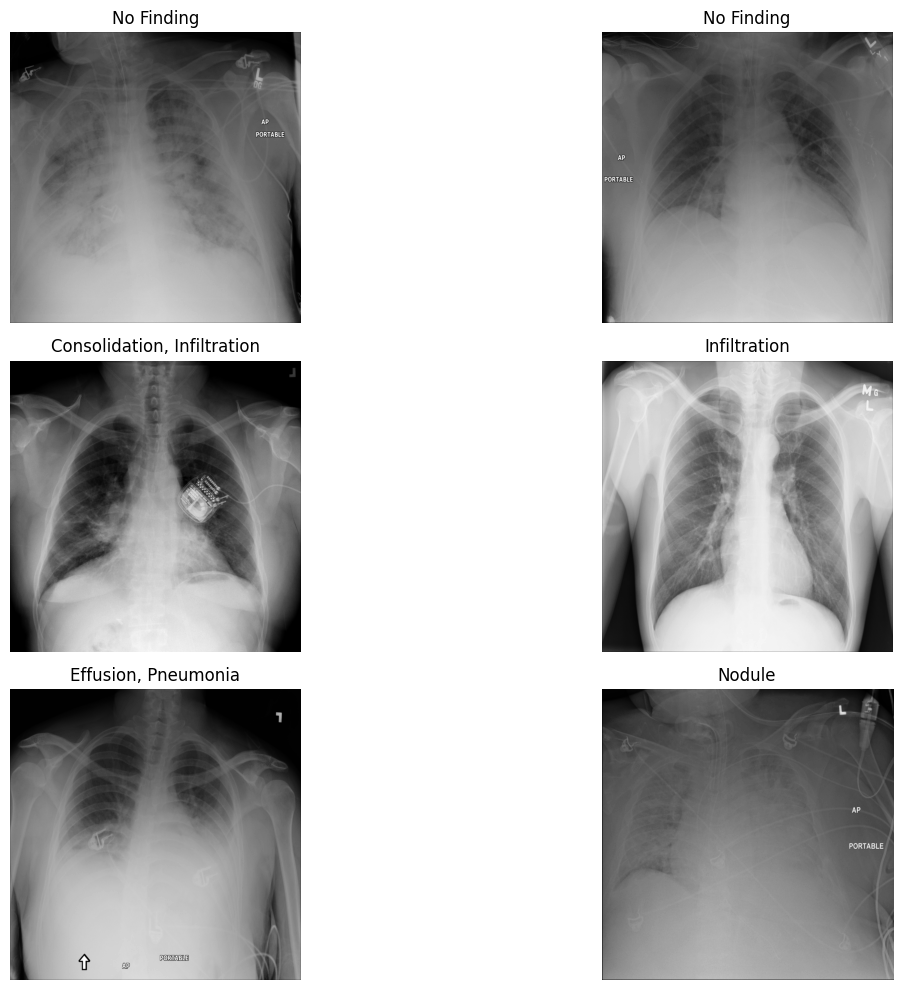

In [33]:
# Define the desired counts for each condition
desired_counts = {'No Finding': 2, 'Consolidation': 1, 'Infiltration': 1, 'Effusion': 1, 'Nodule': 1}

# Get the list of all image paths
try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")

selected_images = []

# For each condition
for label, count in desired_counts.items():
    # Sample the desired number of images for this condition
    condition_images = df[df[label] == 1].sample(min(count, 1000))['Image Index'].values
    selected_images.extend(condition_images)

fig, axes = plt.subplots(3, 2, figsize=(15, 10))

for i, img_name in enumerate(selected_images):
    img_path = [path for path in image_paths if img_name in path][0]  # Find the corresponding image path using img_name
    img = mpimg.imread(img_path)
    
    # Get the condition(s) for this image
    conditions = df.columns[(df.loc[df['Image Index'] == img_name] == 1).values[0]]
    
    row = i // 2
    col = i % 2
    
    ax = axes[row, col]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(', '.join(conditions))

if len(selected_images) < 6:
    for i in range(len(selected_images), 6):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [34]:
df.tail()

Image Index  Follow-up #  Patient ID  Patient Age Patient Gender  \
112115  00030801_001.png            1       30801           39              M   
112116  00030802_000.png            0       30802           29              M   
112117  00030803_000.png            0       30803           42              F   
112118  00030804_000.png            0       30804           30              F   
112119  00030805_000.png            0       30805           27              M   

        No Finding  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  \
112115           0             0              0      0         0          0   
112116           1             0              0      0         0          0   
112117           1             0              0      0         0          0   
112118           1             0              0      0         0          0   
112119           1             0              0      0         0          0   

        Fibrosis  Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  \
112115         0       0             0     1       0                   0   
112116         0       0             0     0       0                   0   
112117         0       0             0     0       0                   0   
112118         0       0             0     0       0                   0   
112119         0       0             0     0       0                   0   

        Pneumonia  Pneumothorax Age Group  
112115          1             0     30-39  
112116          0             0     20-29  
112117          0             0     40-49  
112118          0             0     30-39  
112119          0             0     20-29

In [35]:
# Define the condition columns
condition_columns = ['No Finding', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Count the number of occurrences for each condition
for column in condition_columns:
    print(f"{column}: {df[column].sum()}")

print(f"Total: {len(df)}")

No Finding: 60353
Cardiomegaly: 2776
Consolidation: 4667
Edema: 2302
Effusion: 13316
Emphysema: 2516
Fibrosis: 1686
Hernia: 227
Infiltration: 19891
Mass: 5779
Nodule: 6331
Pleural_Thickening: 3384
Pneumonia: 1430
Pneumothorax: 5301
Total: 112104


In [36]:
# Define the condition columns
condition_columns = ['No Finding', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Create a new column 'num_conditions' that is the sum of the condition columns
df['num_conditions'] = df[condition_columns].sum(axis=1)

# Filter out the rows where 'num_conditions' is greater than 1
df_single_condition = df[df['num_conditions'] <= 1]

# Drop the 'num_conditions' column as it's no longer needed
df_single_condition = df_single_condition.drop(columns='num_conditions')

df_single_condition.tail()

Image Index  Follow-up #  Patient ID  Patient Age Patient Gender  \
112114  00030801_000.png            0       30801           39              M   
112116  00030802_000.png            0       30802           29              M   
112117  00030803_000.png            0       30803           42              F   
112118  00030804_000.png            0       30804           30              F   
112119  00030805_000.png            0       30805           27              M   

        No Finding  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  \
112114           1             0              0      0         0          0   
112116           1             0              0      0         0          0   
112117           1             0              0      0         0          0   
112118           1             0              0      0         0          0   
112119           1             0              0      0         0          0   

        Fibrosis  Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  \
112114         0       0             0     0       0                   0   
112116         0       0             0     0       0                   0   
112117         0       0             0     0       0                   0   
112118         0       0             0     0       0                   0   
112119         0       0             0     0       0                   0   

        Pneumonia  Pneumothorax Age Group  
112114          0             0     30-39  
112116          0             0     20-29  
112117          0             0     40-49  
112118          0             0     30-39  
112119          0             0     20-29

In [37]:
# Define the condition columns
condition_columns = ['No Finding', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Count the number of occurrences for each condition
for column in condition_columns:
    print(f"{column}: {df_single_condition[column].sum()}")

print(f"Total: {len(df_single_condition)}")

No Finding: 60353
Cardiomegaly: 1181
Consolidation: 1708
Edema: 675
Effusion: 5122
Emphysema: 1009
Fibrosis: 831
Hernia: 131
Infiltration: 10896
Mass: 2317
Nodule: 2906
Pleural_Thickening: 1243
Pneumonia: 430
Pneumothorax: 2434
Total: 95450


In [38]:
df_single_condition.head()

Image Index  Follow-up #  Patient ID  Patient Age Patient Gender  \
0  00000001_000.png            0           1           58              M   
3  00000002_000.png            0           2           81              M   
4  00000003_000.png            0           3           81              F   
5  00000003_001.png            1           3           74              F   
6  00000003_002.png            2           3           75              F   

   No Finding  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  \
0           0             1              0      0         0          0   
3           1             0              0      0         0          0   
4           0             0              0      0         0          0   
5           0             0              0      0         0          0   
6           0             0              0      0         0          0   

   Fibrosis  Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  \
0         0       0             0     0       0                   0   
3         0       0             0     0       0                   0   
4         0       1             0     0       0                   0   
5         0       1             0     0       0                   0   
6         0       1             0     0       0                   0   

   Pneumonia  Pneumothorax Age Group  
0          0             0     50-59  
3          0             0     80-89  
4          0             0     80-89  
5          0             0     70-79  
6          0             0     70-79

In [39]:
max_samples_per_condition = 1000
sampled_dfs = []

# Define the condition columns
condition_columns = ['No Finding', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

for label in condition_columns:
    # Get the rows where the current condition is present
    condition_df = df_single_condition[df_single_condition[label] == 1]
    
    # If the number of images for this condition is more than max_samples_per_condition, sample it
    if len(condition_df) > max_samples_per_condition:
        condition_df = condition_df.sample(n=max_samples_per_condition, random_state=42)
    
    sampled_dfs.append(condition_df)

# Concatenate all the dataframes
sampled_df = pd.concat(sampled_dfs, ignore_index=True)

In [40]:
print(len(sampled_df))

12067


In [41]:
sampled_df.tail()

Image Index  Follow-up #  Patient ID  Patient Age Patient Gender  \
12062  00011355_012.png           12       11355           34              M   
12063  00002817_009.png            9        2817           67              F   
12064  00003722_010.png           10        3722           55              M   
12065  00018960_012.png           12       18960           27              M   
12066  00018865_046.png           46       18865           71              F   

       No Finding  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  \
12062           0             0              0      0         0          0   
12063           0             0              0      0         0          0   
12064           0             0              0      0         0          0   
12065           0             0              0      0         0          0   
12066           0             0              0      0         0          0   

       Fibrosis  Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  \
12062         0       0             0     0       0                   0   
12063         0       0             0     0       0                   0   
12064         0       0             0     0       0                   0   
12065         0       0             0     0       0                   0   
12066         0       0             0     0       0                   0   

       Pneumonia  Pneumothorax Age Group  
12062          0             1     30-39  
12063          0             1     60-69  
12064          0             1     50-59  
12065          0             1     20-29  
12066          0             1     70-79

In [42]:
# Load the images
root_folder = "/kaggle/input/data/"

try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")
    

In [43]:
df = sampled_df # Do not reduce the number of conditions

In [44]:
df.tail()

Image Index  Follow-up #  Patient ID  Patient Age Patient Gender  \
12062  00011355_012.png           12       11355           34              M   
12063  00002817_009.png            9        2817           67              F   
12064  00003722_010.png           10        3722           55              M   
12065  00018960_012.png           12       18960           27              M   
12066  00018865_046.png           46       18865           71              F   

       No Finding  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  \
12062           0             0              0      0         0          0   
12063           0             0              0      0         0          0   
12064           0             0              0      0         0          0   
12065           0             0              0      0         0          0   
12066           0             0              0      0         0          0   

       Fibrosis  Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  \
12062         0       0             0     0       0                   0   
12063         0       0             0     0       0                   0   
12064         0       0             0     0       0                   0   
12065         0       0             0     0       0                   0   
12066         0       0             0     0       0                   0   

       Pneumonia  Pneumothorax Age Group  
12062          0             1     30-39  
12063          0             1     60-69  
12064          0             1     50-59  
12065          0             1     20-29  
12066          0             1     70-79

In [45]:
%%capture

def create_image_path_series(directory):
    if not os.path.isdir(directory):
        raise FileNotFoundError(f"Directory '{directory}' not found.")

    image_paths = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            try:
                filepath = os.path.join(dirname, filename)
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(filepath)
            except OSError as e:
                print(f"Error processing file '{filepath}': {e}")

    return pd.Series(image_paths, index=image_paths)

directory = "/kaggle/input"

try:
    image_path_series = create_image_path_series(directory)
    print(image_path_series)
except (FileNotFoundError, ValueError) as e:
    print(e)

In [46]:
df.head()

Image Index  Follow-up #  Patient ID  Patient Age Patient Gender  \
0  00006763_000.png            0        6763           13              M   
1  00024140_000.png            0       24140           33              M   
2  00023779_000.png            0       23779           29              F   
3  00013090_002.png            2       13090           76              M   
4  00018175_015.png           15       18175           56              M   

   No Finding  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  \
0           1             0              0      0         0          0   
1           1             0              0      0         0          0   
2           1             0              0      0         0          0   
3           1             0              0      0         0          0   
4           1             0              0      0         0          0   

   Fibrosis  Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  \
0         0       0             0     0       0                   0   
1         0       0             0     0       0                   0   
2         0       0             0     0       0                   0   
3         0       0             0     0       0                   0   
4         0       0             0     0       0                   0   

   Pneumonia  Pneumothorax Age Group  
0          0             0     10-19  
1          0             0     30-39  
2          0             0     20-29  
3          0             0     70-79  
4          0             0     50-59

In [47]:
df['Filepath'] = image_path_series[image_paths]

In [48]:
df.head()

Image Index  Follow-up #  Patient ID  Patient Age Patient Gender  \
0  00006763_000.png            0        6763           13              M   
1  00024140_000.png            0       24140           33              M   
2  00023779_000.png            0       23779           29              F   
3  00013090_002.png            2       13090           76              M   
4  00018175_015.png           15       18175           56              M   

   No Finding  Cardiomegaly  Consolidation  Edema  Effusion  ...  Fibrosis  \
0           1             0              0      0         0  ...         0   
1           1             0              0      0         0  ...         0   
2           1             0              0      0         0  ...         0   
3           1             0              0      0         0  ...         0   
4           1             0              0      0         0  ...         0   

   Hernia  Infiltration  Mass  Nodule  Pleural_Thickening  Pneumonia  \
0       0             0     0       0                   0          0   
1       0             0     0       0                   0          0   
2       0             0     0       0                   0          0   
3       0             0     0       0                   0          0   
4       0             0     0       0                   0          0   

   Pneumothorax  Age Group Filepath  
0             0      10-19      NaN  
1             0      30-39      NaN  
2             0      20-29      NaN  
3             0      70-79      NaN  
4             0      50-59      NaN  

[5 rows x 21 columns]

In [49]:
directory_path = '/kaggle/input/final01/' 
file_path = os.path.join(directory_path, 'final.py')

sys.path.append(directory_path)

try:
    from final import ChestXRayDataset
    print("Import successful.")
except Exception as e:
    print(f"Import failed with the following error: {e}")

Import successful.


In [50]:
from tqdm.notebook import tqdm
for index, row in tqdm(df.iterrows(), total=len(df)):
    filename = row['Image Index']
    for path_index, path in image_path_series.items():
        if filename in path:
            df.loc[index, 'Filepath'] = path
            break

  0%|          | 0/12067 [00:00<?, ?it/s]

In [51]:
# Map condition names to class indices
condition_to_index = {condition: idx for idx, condition in enumerate(condition_columns)}

# Create a new 'Label' column with class indices
df['Label'] = df[condition_columns].idxmax(axis=1).map(condition_to_index)

In [52]:
# Drop the condition columns and others
df = df.drop(columns=['Follow-up #', 'Patient ID','No Finding', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])

In [53]:
df.tail()

Image Index  Patient Age Patient Gender Age Group  \
12062  00011355_012.png           34              M     30-39   
12063  00002817_009.png           67              F     60-69   
12064  00003722_010.png           55              M     50-59   
12065  00018960_012.png           27              M     20-29   
12066  00018865_046.png           71              F     70-79   

                                                Filepath  Label  
12062  /kaggle/input/data/images_005/images/00011355_...     13  
12063  /kaggle/input/data/images_002/images/00002817_...     13  
12064  /kaggle/input/data/images_002/images/00003722_...     13  
12065  /kaggle/input/data/images_009/images/00018960_...     13  
12066  /kaggle/input/data/images_009/images/00018865_...     13

In [54]:
# Move 'Label' column right after 'Image Index'
columns = ['Image Index', 'Label'] + [col for col in df.columns if col not in ['Image Index', 'Label']]
df = df[columns]

# Verify the updated DataFrame
df.head()

Image Index  Label  Patient Age Patient Gender Age Group  \
0  00006763_000.png      0           13              M     10-19   
1  00024140_000.png      0           33              M     30-39   
2  00023779_000.png      0           29              F     20-29   
3  00013090_002.png      0           76              M     70-79   
4  00018175_015.png      0           56              M     50-59   

                                            Filepath  
0  /kaggle/input/data/images_004/images/00006763_...  
1  /kaggle/input/data/images_010/images/00024140_...  
2  /kaggle/input/data/images_010/images/00023779_...  
3  /kaggle/input/data/images_006/images/00013090_...  
4  /kaggle/input/data/images_008/images/00018175_...

In [55]:
# Map condition names to class indices
condition_to_index = {condition: idx for idx, condition in enumerate(condition_columns)}

# Create inverse mapping: index to condition
index_to_condition = {v: k for k, v in condition_to_index.items()}

# Map integer labels back to condition names
df['Label'] = df['Label'].map(index_to_condition)

# Ensure labels are strings
df['Label'] = df['Label'].astype(str)

# # Drop unnecessary columns if not already done
# df = df.drop(columns=condition_columns)

# # Rearrange columns if needed
# columns = ['Image Index', 'Label'] + [col for col in df.columns if col not in ['Image Index', 'Label']]
# df = df[columns]


In [56]:
df.tail()

Image Index         Label  Patient Age Patient Gender Age Group  \
12062  00011355_012.png  Pneumothorax           34              M     30-39   
12063  00002817_009.png  Pneumothorax           67              F     60-69   
12064  00003722_010.png  Pneumothorax           55              M     50-59   
12065  00018960_012.png  Pneumothorax           27              M     20-29   
12066  00018865_046.png  Pneumothorax           71              F     70-79   

                                                Filepath  
12062  /kaggle/input/data/images_005/images/00011355_...  
12063  /kaggle/input/data/images_002/images/00002817_...  
12064  /kaggle/input/data/images_002/images/00003722_...  
12065  /kaggle/input/data/images_009/images/00018960_...  
12066  /kaggle/input/data/images_009/images/00018865_...

# Machine Learning Section -

## keras

In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np
import pandas as pd

# 1. Split the data into train, val, test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['Label'])  # 0.25 x 0.8 = 0.2

# **Oversample minority classes in the training set**

# Get the class counts
class_counts = train_df['Label'].value_counts()
max_count = class_counts.max()

# Initialize a list to hold the resampled DataFrames
resampled_dfs = []

# Resample each class to have the same number of samples as the majority class
for label in class_counts.index:
    class_df = train_df[train_df['Label'] == label]
    resampled_class_df = resample(
        class_df,
        replace=True,  # Sample with replacement
        n_samples=max_count,  # Match number of samples in majority class
        random_state=42  # For reproducibility
    )
    resampled_dfs.append(resampled_class_df)

# Concatenate all resampled DataFrames
train_df_balanced = pd.concat(resampled_dfs)

# Shuffle the DataFrame
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Apply data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Create data generators
target_size = (224, 224)
batch_size = 32

# Use the balanced training DataFrame
train_generator = train_datagen.flow_from_dataframe(
    train_df_balanced,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

# **No need to compute class weights since classes are now balanced**

# 4. Build the model using transfer learning
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (except the last few layers)
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(14, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# 7. Train the model
epochs = 30

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
    # Removed class_weight parameter since the data is now balanced
)

# 8. Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

2024-10-05 18:19:37.789440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 18:19:37.789626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 18:19:37.920888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 8400 validated image filenames belonging to 14 classes.
Found 2414 validated image filenames belonging to 14 classes.
Found 2414 validated image filenames belonging to 14 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/263 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.0938 - loss: 3.5278   

I0000 00:00:1728152453.009448      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


263/263 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.0964 - loss: 2.8923 - val_accuracy: 0.1243 - val_loss: 2.5565 - learning_rate: 1.0000e-04
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 245s 909ms/step - accuracy: 0.1495 - loss: 2.5314 - val_accuracy: 0.1342 - val_loss: 2.5289 - learning_rate: 1.0000e-04
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 242s 900ms/step - accuracy: 0.1780 - loss: 2.4659 - val_accuracy: 0.1582 - val_loss: 2.4771 - learning_rate: 1.0000e-04
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 244s 908ms/step - accuracy: 0.1992 - loss: 2.4031 - val_accuracy: 0.1719 - val_loss: 2.4434 - learning_rate: 1.0000e-04
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 242s 900ms/step - accuracy: 0.2223 - loss: 2.3504 - val_accuracy: 0.1943 - val_loss: 2.3986 - learning_rate: 1.0000e-04
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 240s 891ms/step - accuracy: 0.2539 - loss: 2.2722 - val_accuracy: 0.2080 - val_loss: 2.3718 - learning_rate: 1.0000e-04
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 239s 889ms/ste

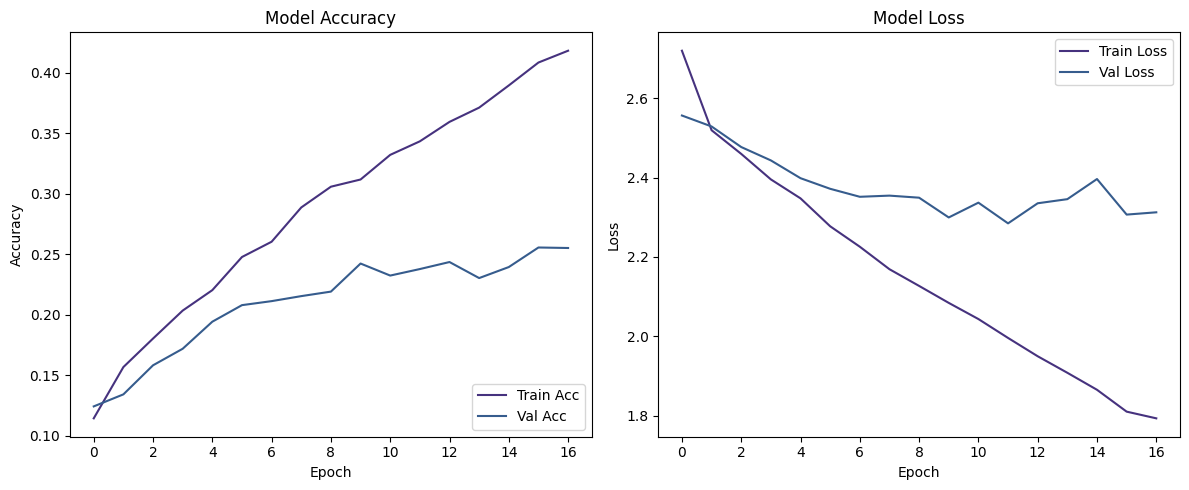

In [58]:
# 9. Plot training history

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# 10. Save the final model
model.save('chest_xray_classification_model.keras')

Found 7239 validated image filenames belonging to 14 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


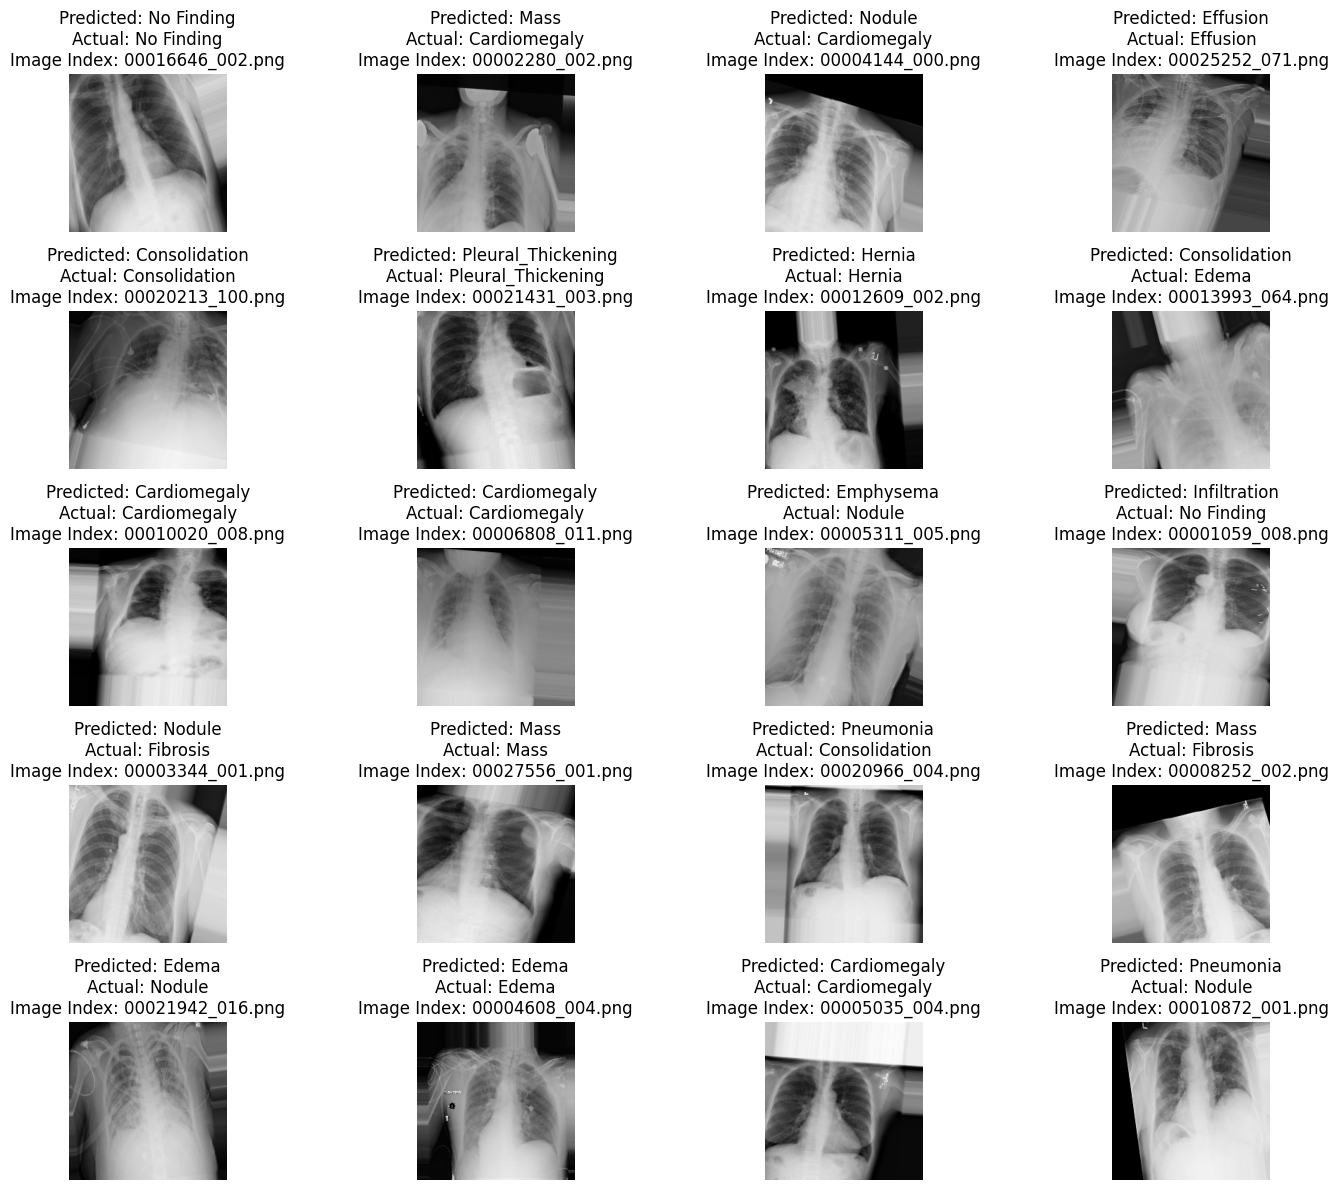

In [59]:
# 1. Reset the index of the DataFrame to align with the generator
train_df = train_df.reset_index(drop=True)

# 2. Create the data generator with shuffle=False to maintain order
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False  # Set shuffle to False to align with DataFrame indices
)

# 3. Get the first batch of images and labels from the training generator
images, labels = next(iter(train_generator))

# 4. Get the 'Image Index' from the DataFrame for the current batch
batch_size = images.shape[0]
batch_df = train_df.iloc[0:batch_size]
image_indices = batch_df['Image Index'].values

# 5. Use the model to predict the class probabilities for the images
predictions = model.predict(images)

# 6. Convert the predictions and labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = labels.astype(int)  # Labels are already integer indices

# 7. Get the mapping from class indices to class names
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

# 8. Get the class names for the predicted and actual classes
predicted_class_names = [index_to_class[i] for i in predicted_classes]
actual_class_names = [index_to_class[i] for i in actual_classes]

# 9. Plot the images with their predicted and actual classes and 'Image Index'
fig, axes = plt.subplots(5, 4, figsize=(15, 12))
axes = axes.ravel()

for i in range(len(axes)):
    if i < len(images):
        # Display the image
        axes[i].imshow(images[i])
        axes[i].axis('off')

        # Get the 'Image Index'
        img_index = image_indices[i]

        # Display the predicted and actual classes along with 'Image Index'
        predicted_class = predicted_class_names[i]
        actual_class = actual_class_names[i]
        axes[i].set_title(f"Predicted: {predicted_class}\nActual: {actual_class}\nImage Index: {img_index}")
    else:
        # Remove any extra subplots
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [60]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions from the model
test_generator.reset()
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels))


76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 601ms/step
                    precision    recall  f1-score   support

      Cardiomegaly       0.38      0.36      0.37       200
     Consolidation       0.20      0.27      0.23       200
             Edema       0.32      0.54      0.40       135
          Effusion       0.36      0.23      0.28       200
         Emphysema       0.28      0.29      0.29       200
          Fibrosis       0.14      0.08      0.10       167
            Hernia       0.12      0.46      0.18        26
      Infiltration       0.07      0.07      0.07       200
              Mass       0.20      0.14      0.16       200
        No Finding       0.17      0.24      0.20       200
            Nodule       0.16      0.10      0.12       200
Pleural_Thickening       0.15      0.08      0.11       200
         Pneumonia       0.06      0.05      0.05        86
      Pneumothorax       0.28      0.31      0.29       200

          accuracy                           0.22      2

76/76 ━━━━━━━━━━━━━━━━━━━━ 36s 471ms/step
                    precision    recall  f1-score   support

      Cardiomegaly       0.38      0.36      0.37       200
     Consolidation       0.20      0.27      0.23       200
             Edema       0.32      0.54      0.40       135
          Effusion       0.36      0.23      0.28       200
         Emphysema       0.28      0.29      0.29       200
          Fibrosis       0.14      0.08      0.10       167
            Hernia       0.12      0.46      0.18        26
      Infiltration       0.07      0.07      0.07       200
              Mass       0.20      0.14      0.16       200
        No Finding       0.17      0.24      0.20       200
            Nodule       0.16      0.10      0.12       200
Pleural_Thickening       0.15      0.08      0.11       200
         Pneumonia       0.06      0.05      0.05        86
      Pneumothorax       0.28      0.31      0.29       200

          accuracy                           0.22      2

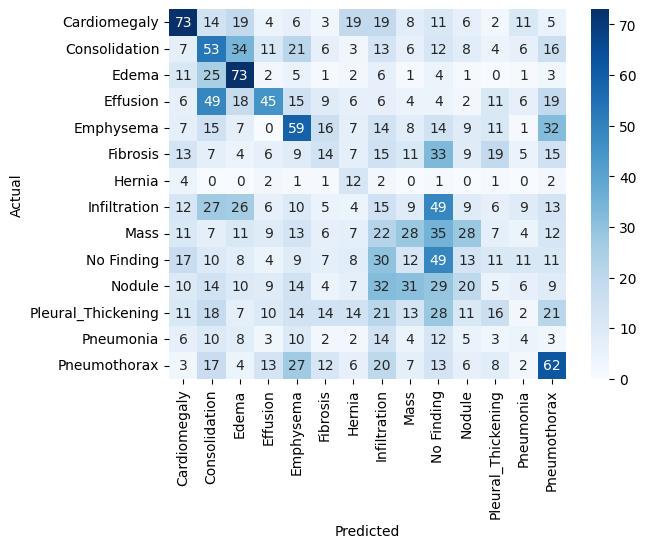

In [61]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict labels for the test set
test_generator.reset()
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [62]:
%%capture
!pip install tf-keras-vis

Found 7239 validated image filenames belonging to 14 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


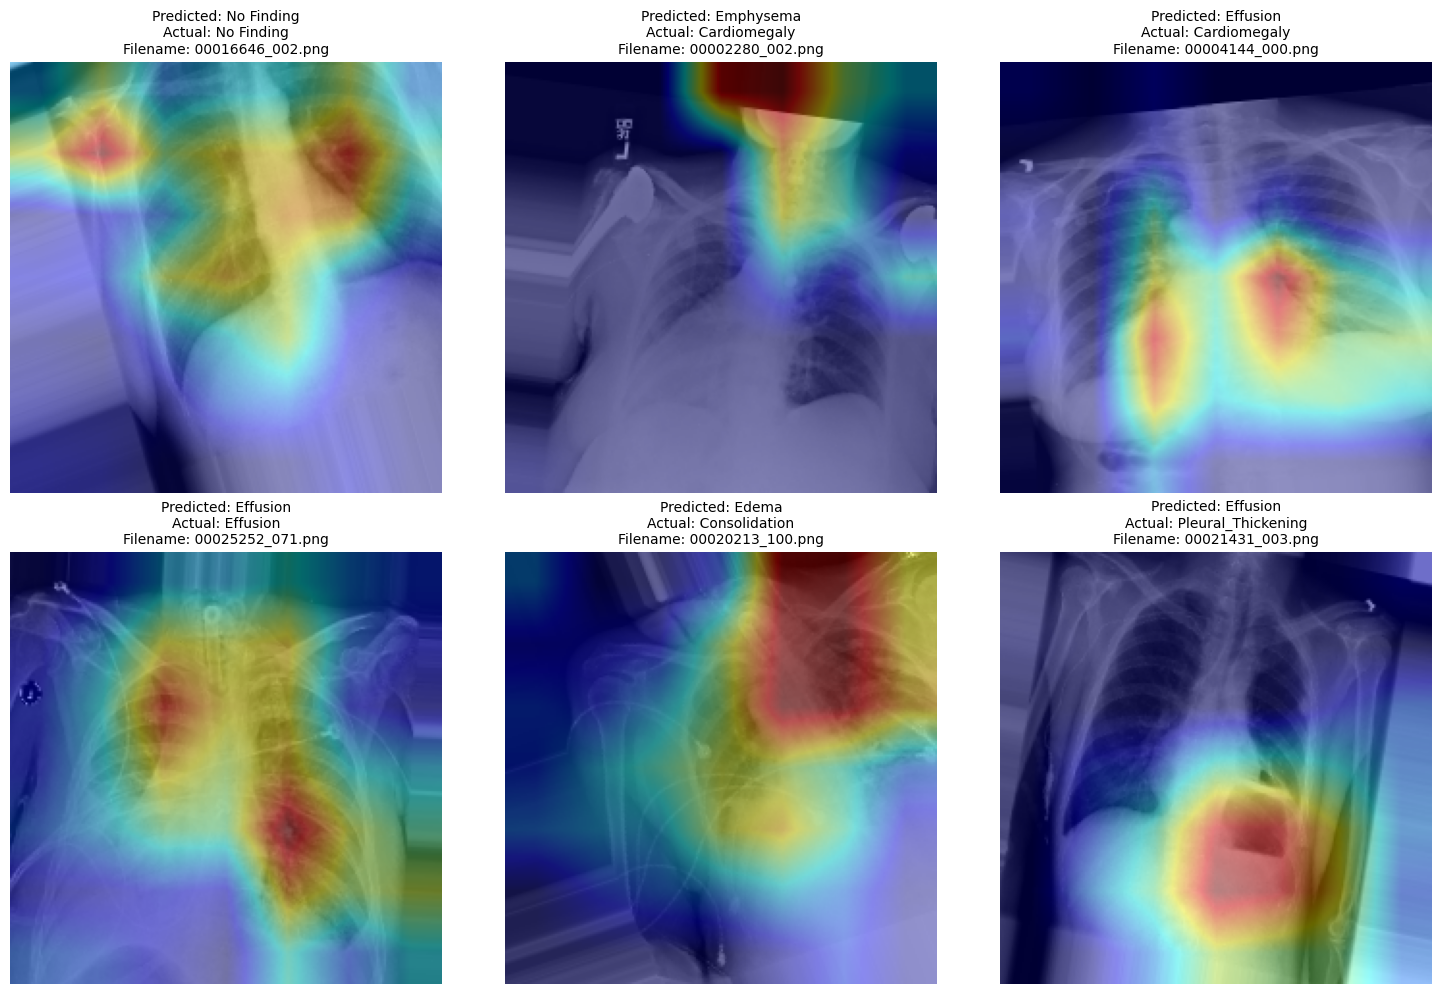

In [63]:
# 1. Reset the index of the DataFrame to align with the generator
train_df = train_df.reset_index(drop=True)

# 2. Create the data generator with shuffle=False to maintain order
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False  # Set shuffle to False to align with DataFrame indices
)

# 3. Get the first batch of images and labels from the training generator
images, labels = next(iter(train_generator))

# 4. Get the 'Image Index' from the DataFrame for the current batch
batch_size = images.shape[0]
batch_df = train_df.iloc[0:batch_size]
image_indices = batch_df['Image Index'].values

# 5. Use the model to predict the class probabilities for the images
predictions = model.predict(images)

# 6. Convert the predictions and labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = labels.astype(int)  # Labels are already integer indices

# 7. Get the mapping from class indices to class names
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

# 8. Get the class names for the predicted and actual classes
predicted_class_names = [index_to_class[i] for i in predicted_classes]
actual_class_names = [index_to_class[i] for i in actual_classes]

# 9. Create grad_model
layer_name = 'conv5_block16_concat'  # Adjust based on your model
grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[model.get_layer(layer_name).output, model.output]
)

# 10. Run gradient tape
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(images)
    # Use actual classes for the loss
    loss = tf.gather_nd(predictions, tf.stack([tf.range(predictions.shape[0]), actual_classes], axis=1))

# 11. Compute gradients
gradients = tape.gradient(loss, conv_outputs)  # shape: (batch_size, H, W, channels)

# 12. Compute pooled gradients
pooled_gradients = tf.reduce_mean(gradients, axis=(1, 2))  # shape: (batch_size, channels)

# 13. Multiply feature maps by pooled gradients
conv_outputs_weighted = conv_outputs * pooled_gradients[:, None, None, :]  # broadcasting

# 14. Sum over channels to get heatmap
heatmap = tf.reduce_sum(conv_outputs_weighted, axis=-1)  # shape: (batch_size, H, W)

# 15. Apply ReLU and normalize
heatmap = tf.nn.relu(heatmap)
heatmap_max = tf.reduce_max(heatmap, axis=(1, 2), keepdims=True)
heatmap = heatmap / (heatmap_max + 1e-10)  # Avoid division by zero

# 16. Convert heatmap to numpy
heatmap = heatmap.numpy()

# 17. Plot the images with Grad-CAM overlays and titles
num_images_to_plot = 6  # Adjust the number of images to display
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(len(axes)):
    if i < num_images_to_plot and i < len(images):
        # Original image
        img = images[i]
        img_uint8 = np.uint8(255 * img)
        
        # Resize heatmap to match the image size
        heatmap_resized = cv2.resize(heatmap[i], (img.shape[1], img.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
        
        # Superimpose the heatmap on the image
        superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)
        
        # Convert from BGR (OpenCV default) to RGB
        superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
        
        # Display the image
        axes[i].imshow(superimposed_img)
        axes[i].axis('off')

        # Get the 'Image Index' (filename)
        img_index = image_indices[i]
        predicted_class = predicted_class_names[i]
        actual_class = actual_class_names[i]

        # Set the title
        axes[i].set_title(
            f"Predicted: {predicted_class}\nActual: {actual_class}\nFilename: {img_index}",
            fontsize=10
        )
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [64]:
# break

In [65]:
%%capture
!pip install keras-tuner

In [66]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(
        units=hp.Int('units', min_value=128, max_value=512, step=64),
        activation='relu'
    )(x)
    x = Dropout(hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1))(x)
    predictions = Dense(14, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-4, 1e-5])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='image_classification'
)

tuner.search(train_generator, epochs=5, validation_data=val_generator)


Trial 5 Complete [00h 22m 38s]
val_accuracy: 0.2560066282749176

Best val_accuracy So Far: 0.2667771279811859
Total elapsed time: 01h 52m 29s
